In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DatabaseDF = pd.read_csv("../CleanedDataset.csv")

In [33]:
DatabaseDF = DatabaseDF.drop(columns = 'Unnamed: 0').fillna(0)

## Definition

The Girvan-Newman algorithim is a type of clustering algorithm that uses the betweenees of edges to detect communities. In a graph where nodes are connected by edges, the betweeness of an edge is measured as the number of shortest paths that use said edge. By systematically removing the edges with the highest betweenes, clusters/modules begin to appear in the graph. Eventually when there are no edges left you are able to determine the relation between the nodes. 

What we will attempt to do is firstly create a graph that is represetned by the different variables in our wells and were the edges are the correlation between said variables. we will then run the Girvan-Newman algorithm to detect if there are any groups of variables that more closely interact with each other

## Graph Creation

In [99]:
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram

For our graph we need to first find the nodes which will be the variables we want to analyze. For now we will remove all categorical variables until a way of getting their correlation is best found

In [41]:
interestedColumns = DatabaseDF.select_dtypes(exclude = ['object']).columns
variableColumns = []

varToCol = {}

for col in interestedColumns:
    var = 'Q("' + col + '")'
    variableColumns.append(var)
    varToCol[var] = col

Next we will create OLS regressions for each variable where the inputs will be every other variable

In [46]:
colToRes = {}

for var in variableColumns:

    ## looking at var 
    function = var + " ~ "

    for additionalvar in variableColumns:
        if (var != additionalvar):
            function += additionalvar + " + "

    function = function[:-3]

    mod = smf.ols(formula = function, data = DatabaseDF)

    res = mod.fit()

    colToRes[varToCol[var]] = res

Now that we have all the regressions fit we can create the graph by adding all the edges for each coefficient between two variables

In [131]:
##colToRes['Lateral Length'].params

G = nx.Graph()

for col in interestedColumns:
    res = colToRes[col]

    for param, value in res.params.items():
        if (param != 'Intercept'):
            secondNode = varToCol[param]
            weight = abs(value)

            G.add_edge(col, secondNode, weight = weight)

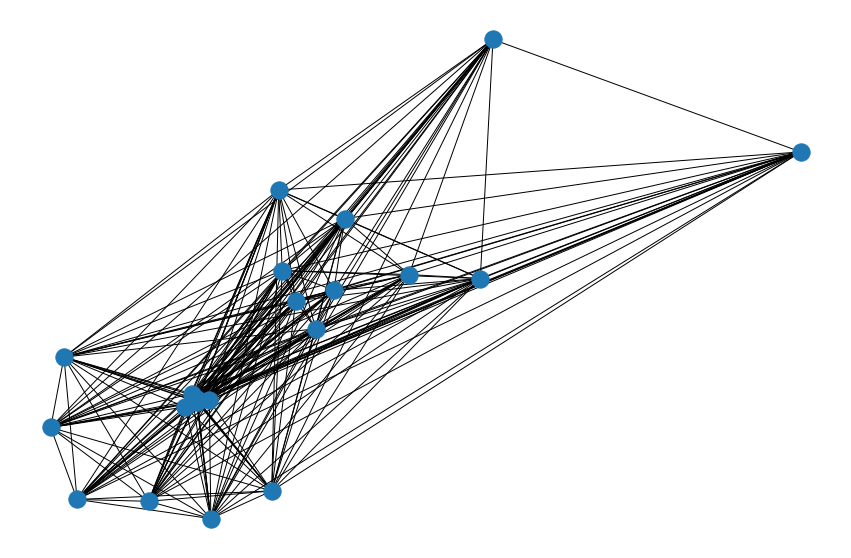

In [134]:
plt.subplots(figsize = (15,10))
nx.draw(G)

## Girvan-Newman Algorithm

Using the above graph we can then run the GN algorithm to create a dendrogram plot of the communities found within our system

In [128]:
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):
    centrality = betweenness(G, weight='weight')
    return max(centrality, key=centrality.get)

To create the dendrogram plot I will use a function ripped straight from stackoverflow 

https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm#:~:text=Plot%20the%20dendrogram%20of%20communities%20found%20by%20NetworkX%20Girvan%2DNewman%20algorithm,-python%20matplotlib%20scipy&text=As%20the%20graph%20breaks%20down,iterator%20over%20tuples%20of%20sets.

credit to user: Giora Simchoni

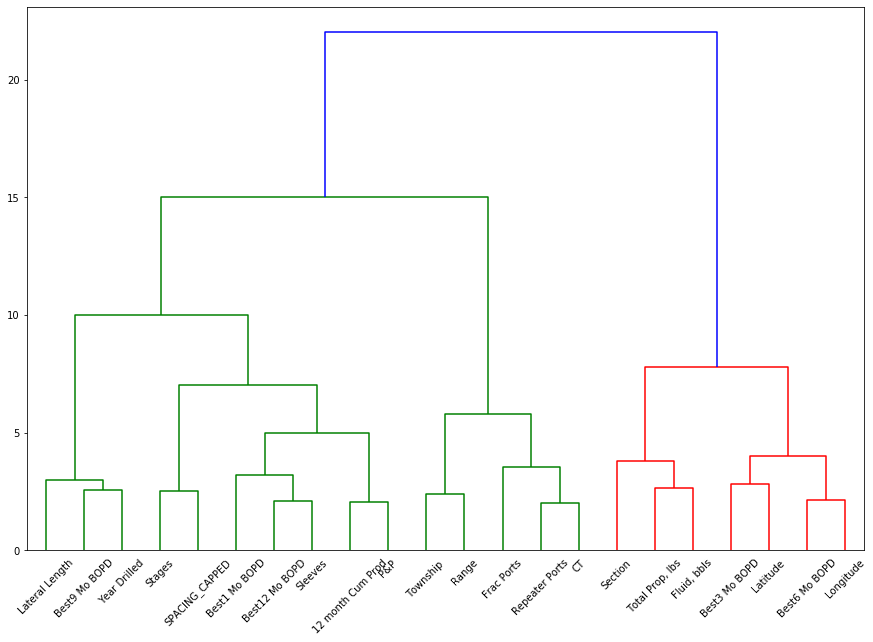

In [141]:
communities = list(nx.community.girvan_newman(G, most_valuable_edge= most_central_edge))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank


# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

Saved = G

# finally using @mdml's magic, slightly modified:
G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last


# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

G = Saved

# dendrogram
plt.figure(figsize = (15,10))
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])

plt.show()

What the dendogram shows is which variables are most clustered based on our betweeness function.